# Application of linear response theory method to individual ensemble members (CESM)
Here, we apply the linear response theory method to individual ensemble members. This is done using the block bootstrapping methodology. We compare to the true value from the notebook true_freshwater_fluxes.ipynb and then apply significance criteria on the salinity trends to select only for members with high enough signal to noise ratio.

In [8]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

In [2]:
# Load in salt and temp fields from each ensemble member. These pickled files were created in the file processing_salt_temp.py

import pickle
with open("/scratch/abf376/regridded_salt_1920to2005_historical", "rb") as fp:   # Unpickling
    regridded_salt= pickle.load(fp)

with open("/scratch/abf376/regridded_salt_2006to2080_rcp8.5", "rb") as fp:   # Unpickling
    regridded_salt_2005on= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp", "rb") as fp:   # Unpickling
    regridded_temp= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp_2006to2080_rcp8.5", "rb") as fp:   # Unpickling
    regridded_temp_2005on= pickle.load(fp)
    

salt_pre2005_list=[] #make list of salt pre 2005 and give it correct coordinates
for i in range(0,34):
    s=regridded_salt[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    salt_pre2005_list.append(s)

salt_2005on_list=[] #make list of salt post 2005 and give it correct coordinates
for i in range(0,34):
    s=regridded_salt_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    salt_2005on_list.append(s)
    
salt_list=[] #combine salt lists from the two time periods and then cut to 1975 to 2025
for i in range(0,34):
    s=xr.concat([salt_pre2005_list[i],salt_2005on_list[i]],dim="time")
    salt_list.append(s[12*55:12*105,:,:]) #cut to 1975 to 2025
    
#same as above but for temperature
temp_pre2005_list=[]
for i in range(0,34):
    s=regridded_temp[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    temp_pre2005_list.append(s)

temp_2005on_list=[]
for i in range(0,34):
    s=regridded_temp_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    temp_2005on_list.append(s)
    
temp_list=[]
for i in range(0,34):
    s=xr.concat([temp_pre2005_list[i],temp_2005on_list[i]],dim="time")
    temp_list.append(s[12*55:12*105,:,:]) #cut to 1975 to 2025

In [6]:
#define an area matrix
import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')
from area_grid import *

area=area_grid(latitudes=np.array(salt_list[0].latitude),longitudes=salt_list[0].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_list[0].latitude,salt_list[0].longitude])

## Example of application to one specific ensemble member

1e+00
(100000, 6)


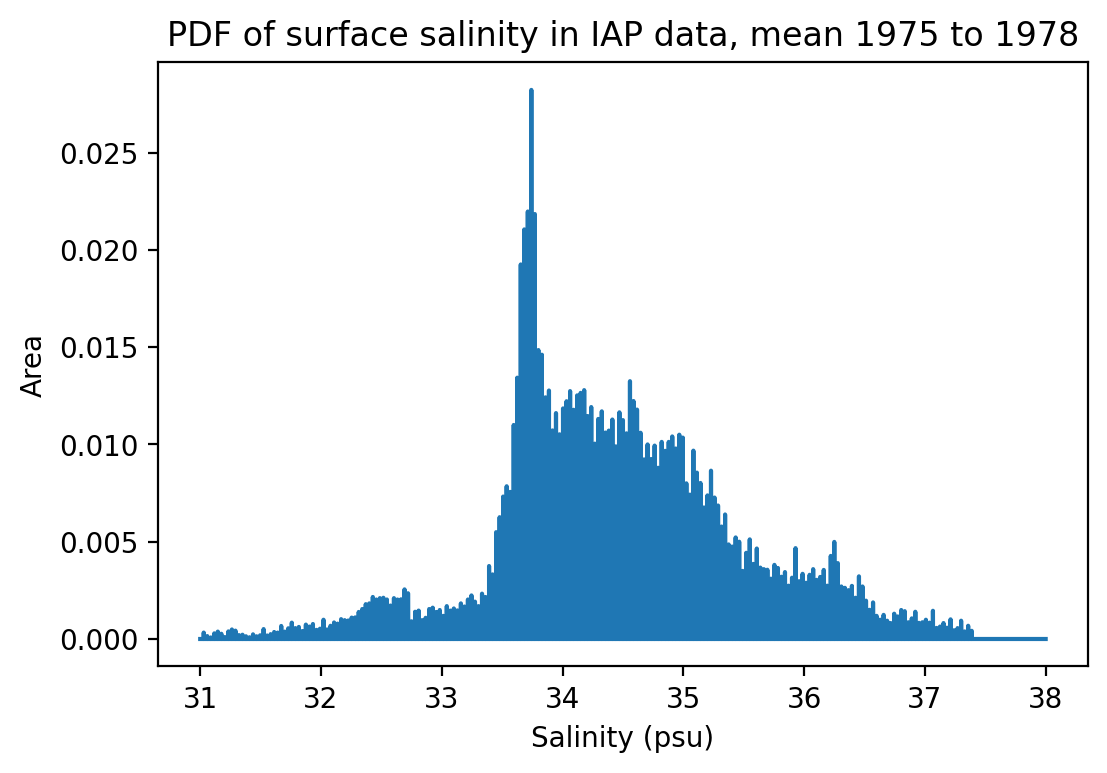

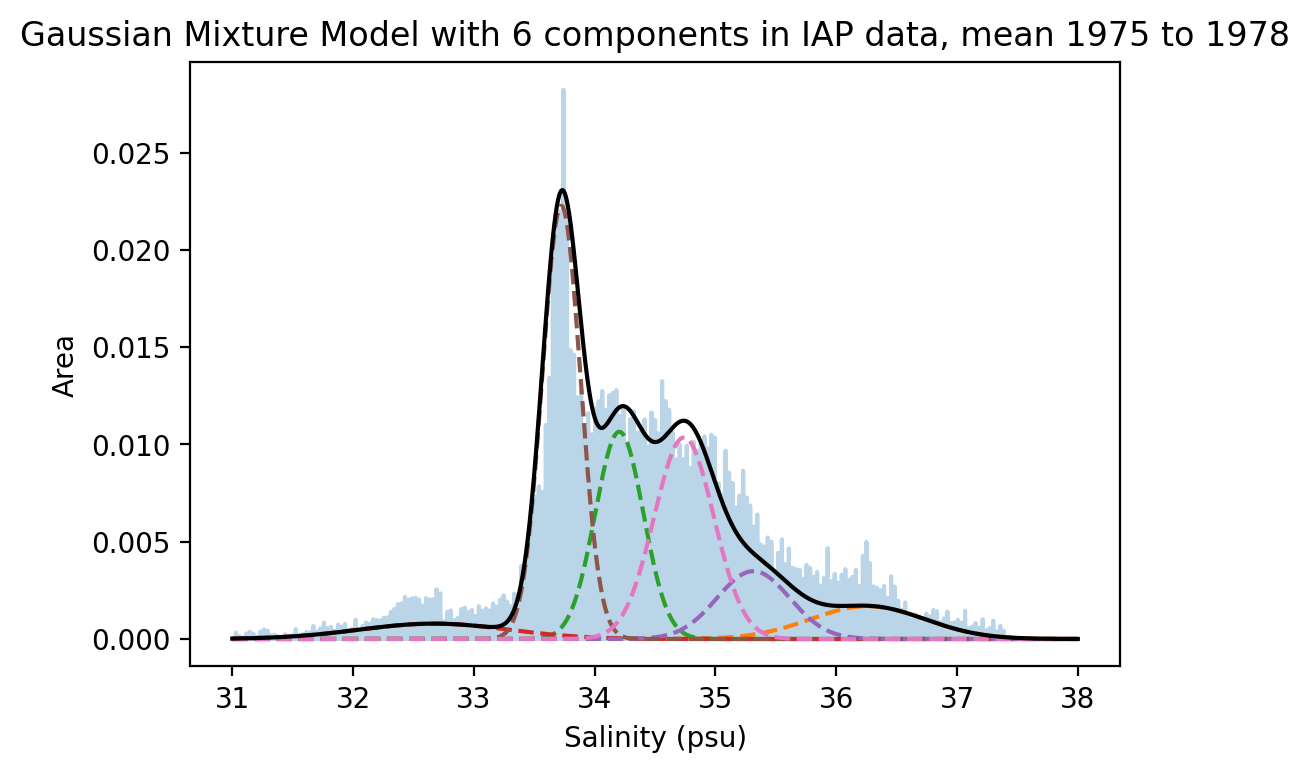

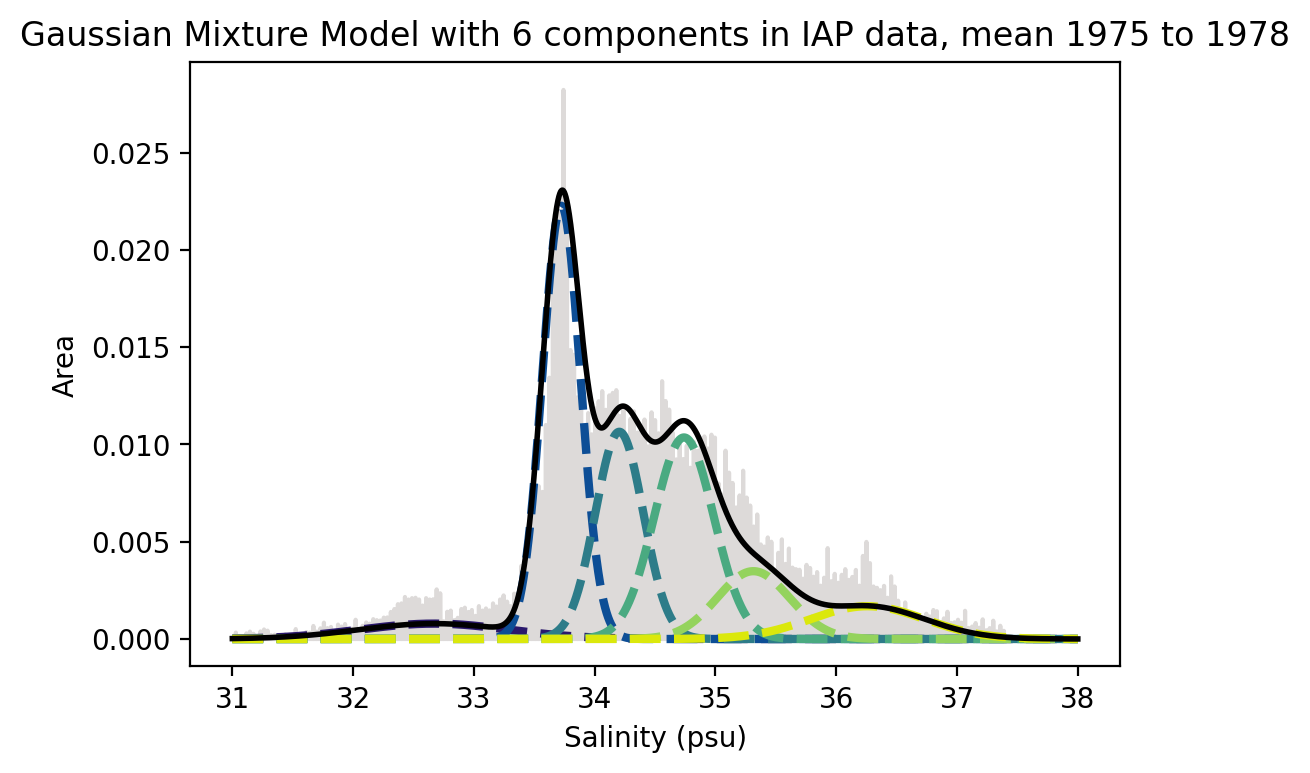

In [7]:
real=0 #realization in the list
n=6


%load_ext autoreload 
%autoreload 2

from clustering_tools import * #do clustering of the first 5 years of the realization
mean_con,sigma_con,weights_con,gm=GMM_timedep(salt_list[real][0*12:5*12,:,:].mean('time').where(salt_list[real][0,:,:].latitude<65),n,'IAP data, mean 1975 to 1978',matching_paper=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


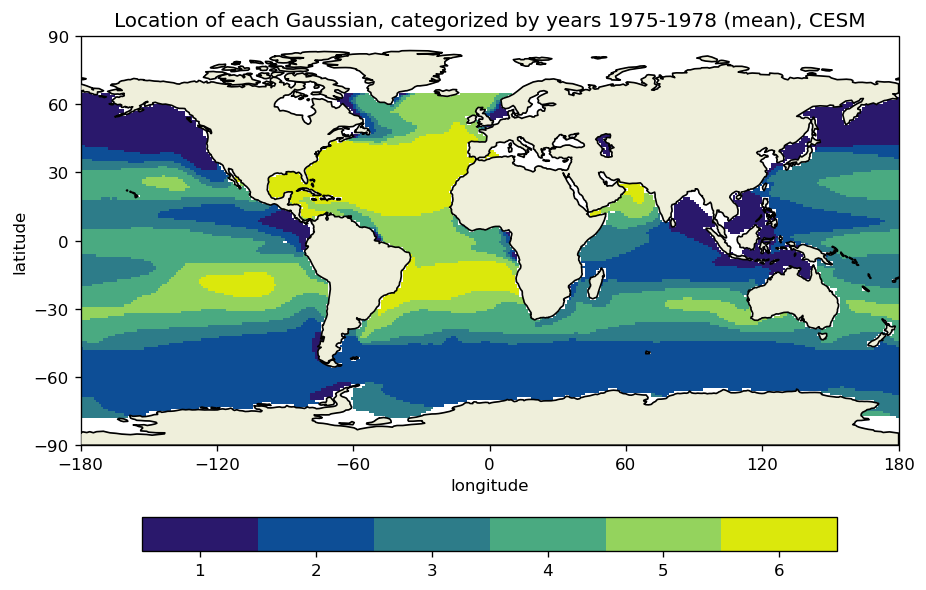

In [8]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2

y,a2=clusters(gm,salt_list[real][0*12:20*12,:,:].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), CESM',n,matching_paper=1) #put on the last parameter if want colours to match the line plots of salinity

In [9]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

In [10]:
#Here we find the mean salinity and temperature in each region found by the GMM above.
x=np.linspace(31,38,10000)

s=(salt_list[real][0*12:5*12,:,:].mean('time')).where(salt_list[real][0,:,:].latitude<65)

salt_cesm_member=np.empty([50,n])
temp_cesm_member=np.empty([50,n])
for j in range(0,50):
    s_new=(salt_list[real][j*12:(j+1)*12,:,:].mean('time')).where(salt_list[real][0,:,:].latitude<65)
    t_new=(temp_list[real][j*12:(j+1)*12,:,:].mean('time')).where(temp_list[real][0,:,:].latitude<65)
    for i in range(0,n):
        salt_cesm_member[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm_member[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
change_cesm_member=salt_cesm_member[:,:]-np.mean(salt_cesm_member[0:2,:],0)
change_cesm_temp_member=temp_cesm_member[:,:]-np.mean(temp_cesm_member[0:2,:],0)

change_cesm_member=change_cesm_member[0:45,:] #cut to the first 45 years (1975 to 2019)
change_cesm_temp_member=change_cesm_temp_member[0:45,:] #cut to the first 45 years (1975 to 2019)

Text(0.5, 1.0, 'Change in salinity in each region, CESM member 0')

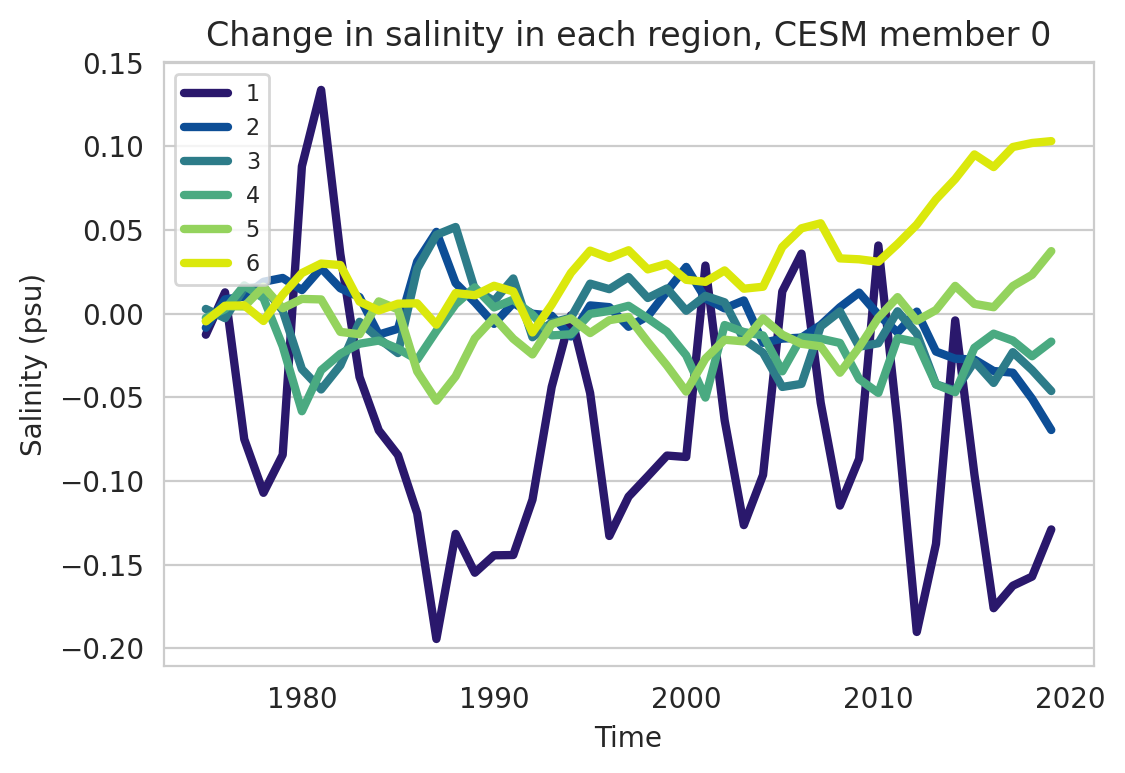

In [11]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_cesm_member,linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, CESM member '+ str(real))

Text(0.5, 1.0, 'Change in temperature in each region, CESM member 0')

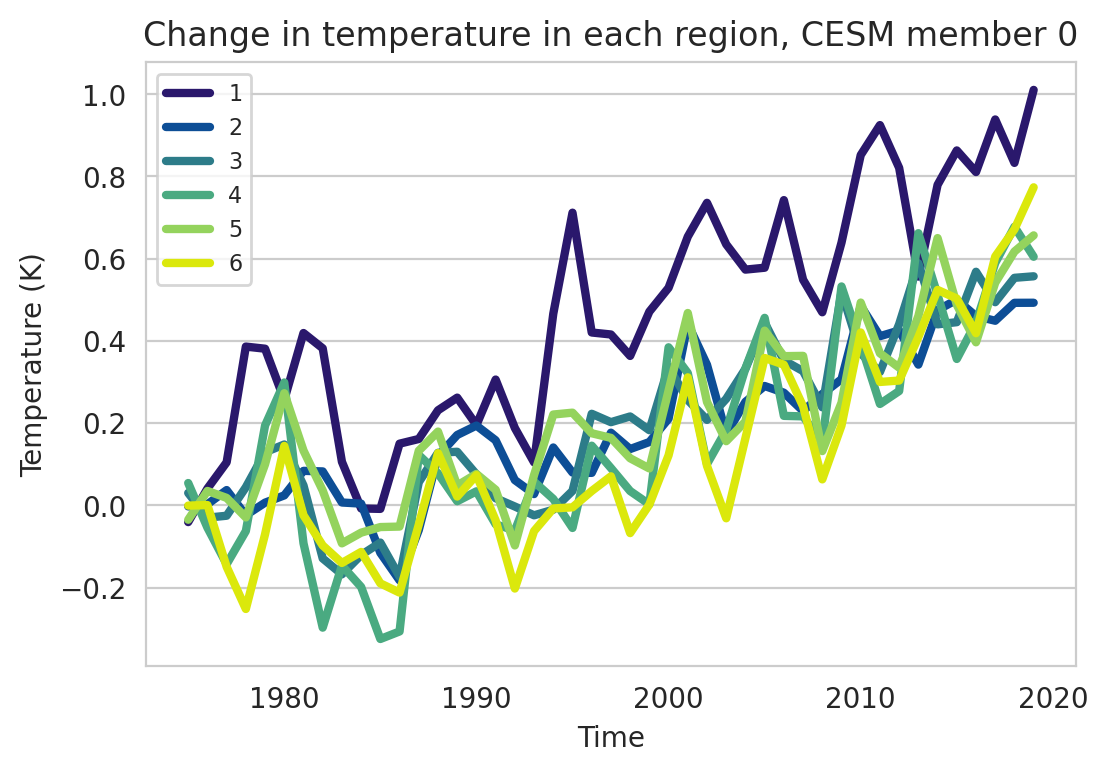

In [12]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_cesm_temp_member,linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region, CESM member '+ str(real))

In [13]:
#Bootstrap around trend to create artificial ensemble. This follows the methodology of McKinnon et al 2017

trend=np.empty([45,6])
pvalue=np.empty([6])
for i in range(0,6):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_cesm_member[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue[i]=p.pvalue

#Find the trend for each region and then block bootstrap
trend_temp=np.empty([45,6])
for i in range(0,6):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_cesm_temp_member[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(np.concatenate([change_cesm_member-trend,change_cesm_temp_member-trend_temp],axis=1), 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap_salt=y_star_cb[:,:,0:6]
bootstrap_temp=y_star_cb[:,:,6:12]

#so we now have 3000 "members" from performing block bootstrapping with the 1 member that we had. Let's put them now in a list
salt_list_bootstrap=[]
for i in range(0,B):
    salt_list_bootstrap.append(trend+bootstrap_salt[i,:,:])

temp_list_bootstrap=[]
for i in range(0,B):
    temp_list_bootstrap.append(trend_temp+bootstrap_temp[i,:,:])

Text(0, 0.5, 'Autocorrelation')

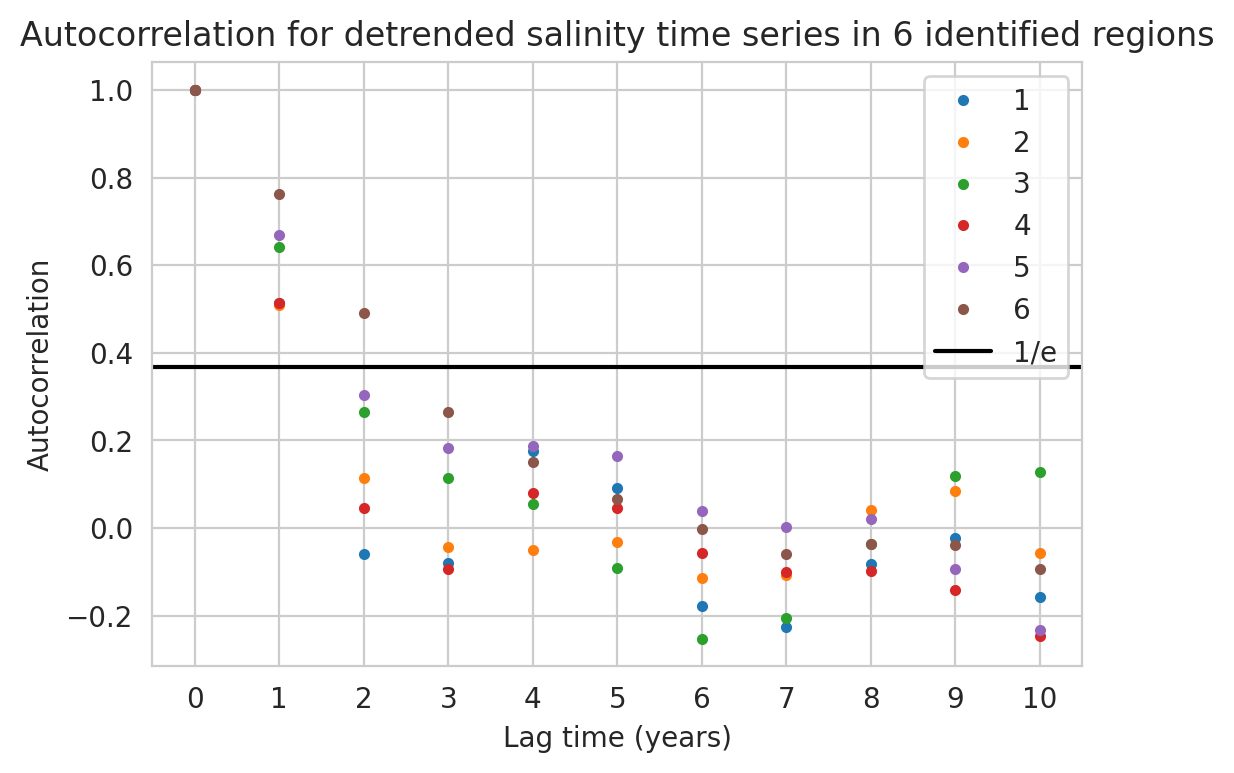

In [14]:
#One way to decide on the approximate window for block bootsrapping is looking at the autocorrelation timescale of the data. (This is how we chose 2 years above)
import statsmodels.api as sm

#calculate autocorrelations
auto_salt=np.empty([11,6])
auto_temp=np.empty([11,6])
for i in range(0,6):
    auto_salt[:,i]=sm.tsa.acf(change_cesm_member[:,i]-trend[:,i],nlags=10)
    auto_temp[:,i]=sm.tsa.acf(change_cesm_temp_member[:,i]-trend_temp[:,i],nlags=10)



plt.plot(np.linspace(0,10,11),auto_salt,'.')
plt.axhline(1/np.e,color='black') #compare against e folding 
plt.legend(['1','2','3','4','5','6','1/e'])
plt.title('Autocorrelation for detrended salinity time series in 6 identified regions')
plt.xlabel('Lag time (years)')
plt.xticks(np.linspace(0,10,11))
plt.ylabel('Autocorrelation')

In [41]:
#Apply linear response theory to the artificial ensemble

from linear_response_tools import linear_response_list_bootstrap
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    change_water1, change_heat1=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,salt_list[real][0:45*12,:,:],n,a2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
#we can print the mean and standard deviation of the freshwater response and of the heat flux response
print('The freshwater response for ensemble member '+str(real)+' is ' + str(change_water1.mean()) +' pm '+str(change_water1.std())+ ' as a proportion of the FAFMIP perturbation')
print('The heat flux response for ensemble member '+str(real)+' is ' + str(change_heat1.mean()) +' pm '+str(change_heat1.std())+ ' as a proportion of the FAFMIP perturbation')

The freshwater response for ensemble member 0 is 0.32219459116968174 pm 0.13598061384377885 as a proportion of the FAFMIP perturbation
The heat flux response for ensemble member 0 is 0.6521720633360166 pm 0.09151396983667541 as a proportion of the FAFMIP perturbation


## Applying to all ensemble members
Above, we showed an example of applying linear response theory to one individual ensemble member by first producting an artificial ensemble using block bootstrapping. We now want to test on all 34 members of the ensemble

In [74]:
# The .py file that runs the above process that we outlined through all 34 members is called run_bootstrap_cesm_ensemble.py
#Let's load in the output from that file here that was pickled

import os
cwd = os.getcwd() #current working directory

import pickle
with open(cwd+"/pickled_files/bootstrap_mean_3000_updateaug24", "rb") as fp:   # Unpickling
    trend_uncertainty_bootstrap_mean_method1= pickle.load(fp)

with open(cwd+"/pickled_files/bootstrap_std_3000_updateaug24", "rb") as fp:   # Unpickling
    trend_uncertainty_bootstrap_std_method1= pickle.load(fp)
    
#unpickle true fluxes from true_freshwater_fluxes.ipynb 
import pickle
with open(cwd+"/pickled_files/freshwater_fluxes_projection_mean_boot", "rb") as fp:   #Unpickling
    mean_boot=pickle.load(fp)
with open(cwd+"/pickled_files/freshwater_fluxes_projection_std_boot", "rb") as fp:   #Unpickling
    std_boot=pickle.load(fp)

Text(0.5, 0.92, 'Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member')

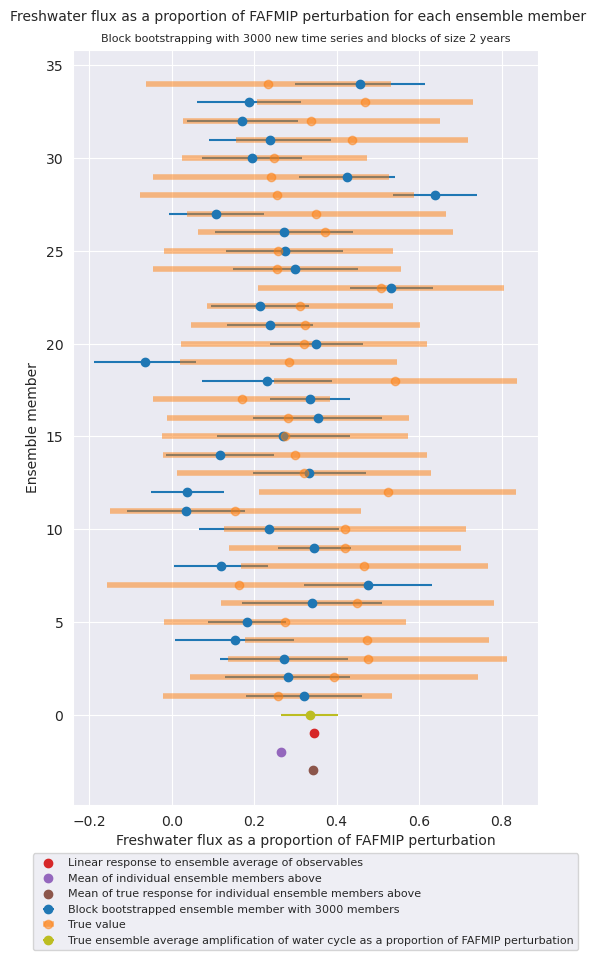

In [34]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(figsize=(6,10))
plt.errorbar(trend_uncertainty_bootstrap_mean_method1, np.linspace(1,34,34),xerr=trend_uncertainty_bootstrap_std_method1,fmt ='o',
        color='tab:blue',ms=6, label='Block bootstrapped ensemble member with 3000 members')
plt.errorbar(mean_boot, np.linspace(1,34,34),xerr=std_boot,fmt ='o', color='tab:orange',alpha=0.5,
        ms=6, elinewidth=4, label='True value')

ax.set_ylabel('Ensemble member')
ax.set_xlabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.errorbar(0.3347435703309112,0,xerr=0.0696193098065107, color='tab:olive',fmt ='o',
        ms=6,label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation') #this value comes from true_freshwater_fluxes.ipynb

ax.scatter(0.3452800298777735,-1,color='tab:red',label='Linear response to ensemble average of observables') #this value comes from linear_response_CESM_ensemblemean.ipynb

ax.scatter(np.average(trend_uncertainty_bootstrap_mean_method1,weights=trend_uncertainty_bootstrap_std_method1),-2,color='tab:purple',label='Mean of individual ensemble members above')
ax.scatter(np.average(mean_boot,weights=std_boot),-3,color='tab:brown',label='Mean of true response for individual ensemble members above')

ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),fontsize=8)
plt.title('Block bootstrapping with 3000 new time series and blocks of size 2 years',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.92)

### Select for ensemble members which meet certain significance criteria
The method above works well for some members and not for others. If we were to look closer, we can see that members that are not capturing the response tend to have insignificant linear trends (compared to the scale of internal variability). One way to see this is choosing ensemble member 18 above in the individual example - here, the p value of the linear trend is insignificant for all regions.

We come up with sufficient (but not necessary) criteria for correctly capturing the true response. First we need to calculate pvalues. We calculate the p value from the confidence interval after bootstrapping (of the change in last 5 years compared to first 5 years). We could pretty equivalently use the p value of the original linear fit to the trend.

In [28]:
# We calculate the two forms of p value for the salt trends in the file  pvalue_salt_trends.py
import os
import pickle
cwd = os.getcwd() #current working directory

with open(cwd+"/pickled_files/pvalue_linear_trends", "rb") as fp:   #Unpickling the pvalues for each region for each ensemble member from the linear trend
    pvalue_store=pickle.load(fp)
with open(cwd+"/pickled_files/pvalue_from_bootstrap", "rb") as fp:   #Unpickling the pvalues for each region for each ensemble member from block bootstrapping
    pvalue_bootstrap_store=pickle.load(fp)

In [10]:
## We first look at the mean of the pvalues in each of the regions across ensemble members
for j in range(0,6):
    print(pvalue_bootstrap_store[:,j].mean())
    
#We see that generally regions 2,6 are significant and regions 1,3,4,5 are not significant - in this case the signal is largely natural variability and not forced resposne

1.308228172132575e-01
0.0489725359205423
0.058488125015546955
0.12897569650813853
0.1531065940541366
0.004712437316236065


In [75]:
# After some playing around, one restriction that seems to guarantee finding the correct response is Let's try regions 2 and 6 have to have p value < 0.05
#regions 1,3,5 have to have p value <0.18. No restrictions for region 4 (doesn't seem to affect)

#Note that we can make these restrictions stricter too - can place a restriction on region 4, but it just eliminates more members that are actually doing well. 

#It is important that these are sufficient but not necessary conditions 

for i in range(0,34):    
    if pvalue_bootstrap_store[i,0]>0.18:
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        
    if pvalue_bootstrap_store[i,1]>0.05:
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

    if pvalue_bootstrap_store[i,2]>0.18: 
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

#no restriction on fourth region
  
    if pvalue_bootstrap_store[i,4]>0.18:
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

    if pvalue_bootstrap_store[i,5]>0.05: 
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan



Text(0.5, 0.92, 'Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member')

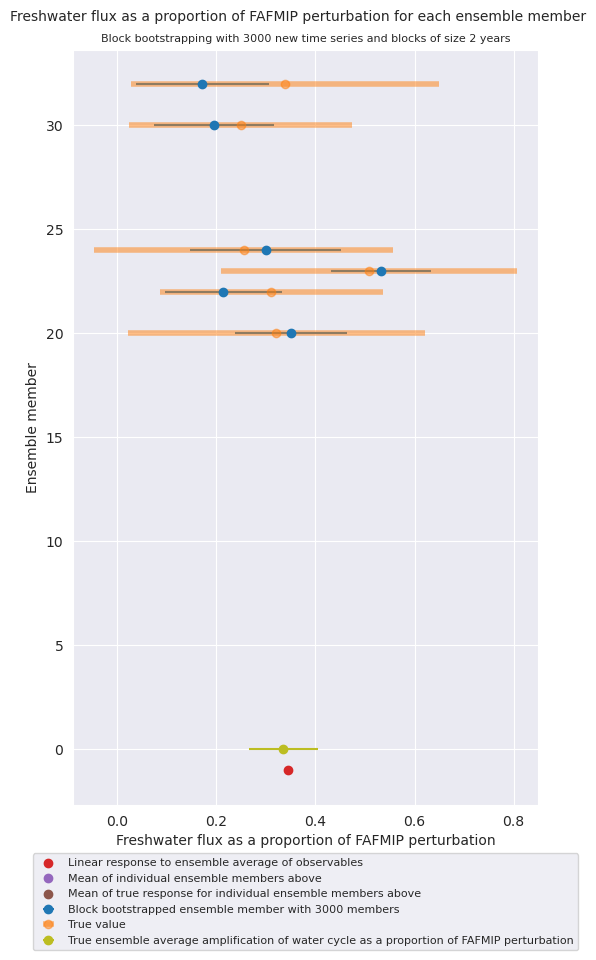

In [76]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(figsize=(6,10))
plt.errorbar(trend_uncertainty_bootstrap_mean_method1, np.linspace(1,34,34),xerr=trend_uncertainty_bootstrap_std_method1,fmt ='o',
        color='tab:blue',ms=6, label='Block bootstrapped ensemble member with 3000 members')
plt.errorbar(mean_boot, np.linspace(1,34,34),xerr=std_boot,fmt ='o', color='tab:orange',alpha=0.5,
        ms=6, elinewidth=4, label='True value')

ax.set_ylabel('Ensemble member')
ax.set_xlabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.errorbar(0.3347435703309112,0,xerr=0.0696193098065107, color='tab:olive',fmt ='o',
        ms=6,label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation') #this value comes from true_freshwater_fluxes.ipynb

ax.scatter(0.3452800298777735,-1,color='tab:red',label='Linear response to ensemble average of observables') #this value comes from linear_response_CESM_ensemblemean.ipynb

ax.scatter(np.average(trend_uncertainty_bootstrap_mean_method1,weights=trend_uncertainty_bootstrap_std_method1),-2,color='tab:purple',label='Mean of individual ensemble members above')
ax.scatter(np.average(mean_boot,weights=std_boot),-3,color='tab:brown',label='Mean of true response for individual ensemble members above')

ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),fontsize=8)
plt.title('Block bootstrapping with 3000 new time series and blocks of size 2 years',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.92)

## Extra tests

### Different block bootstrap lengths
Above, we used 2 years for the block bootstrapping interval, motivated by the autocorrelation timescale of the salinity timeseries. Here we apply linear response theory to an individual ensemble member after using varying block sizes when performing block bootstrapping for the artificial ensemble. We see that the choice of block size has very little impact on the final freshwater amplification value found by linear response theory.

#Note, this section cannot be run unless the section "Example of application to one specific ensemble member" is run. Regardless, this section will take quite while to run, and it is best not to run it inside of this notebook unless needed.

In [15]:
#For a single realization, this iterates through block sizes 2 through 6. For each block size, an artificial ensemble is generated around the linear trend and then linear response theory is applied as above

mean_block_size=np.empty(4) #store the means of applying linear response theory with varying block size
std_block_size=np.empty(4) #store the standard deviations of applying linear response theory with varying block size


for j in range(2,6):
    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 500

    y_star_cb \
        = circular_block_bootstrap(np.concatenate([change_cesm_member-trend,change_cesm_temp_member-trend_temp],axis=1), 
                                   block_length=j, 
                                   replications=B, replace=True)
    bootstrap_salt=y_star_cb[:,:,0:6]
    bootstrap_temp=y_star_cb[:,:,6:12]

    salt_list_bootstrap=[]
    for i in range(0,B):
        salt_list_bootstrap.append(trend+bootstrap_salt[i,:,:])

    temp_list_bootstrap=[]
    for i in range(0,B):
        temp_list_bootstrap.append(trend_temp+bootstrap_temp[i,:,:])
                                   
    n=6
    from linear_response_tools import linear_response_list_bootstrap
    %load_ext autoreload
    %autoreload 2
    with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
        warnings.filterwarnings('ignore')
        change_water1, change_heat1=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,salt_list[real][0:45*12,:,:],n,a2)
                            
    mean_block_size[j-2]=change_water1.mean()
    std_block_size[j-2]=change_water1.std()
    print(j)
 
dep_block_size=np.array([mean_block_size,std_block_size])
import pickle
with open("freshwater_mean_std_blocksizes_2to5_500members_ensemblemember"+str(real), "wb") as fp:   #Pickling so we don't have to rerun
    pickle.dump(dep_block_size, fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5


In [22]:
#To skip running the above block, we can just unpickle what we pickled above
import pickle
import os
cwd = os.getcwd() #current working directory

with open(cwd+"/pickled_files/freshwater_mean_std_blocksizes_2to5_500members_ensemblemember"+str(real), "rb") as fp:   #Pickling so we don't have to rerun
    dep_block_size=pickle.load(fp)

Text(0.5, 1.0, 'Freshwater flux as a proportion of FAFMIP perturbation for varying block size with block bootstrapping of CESM Ensemble member 0, 500 members')

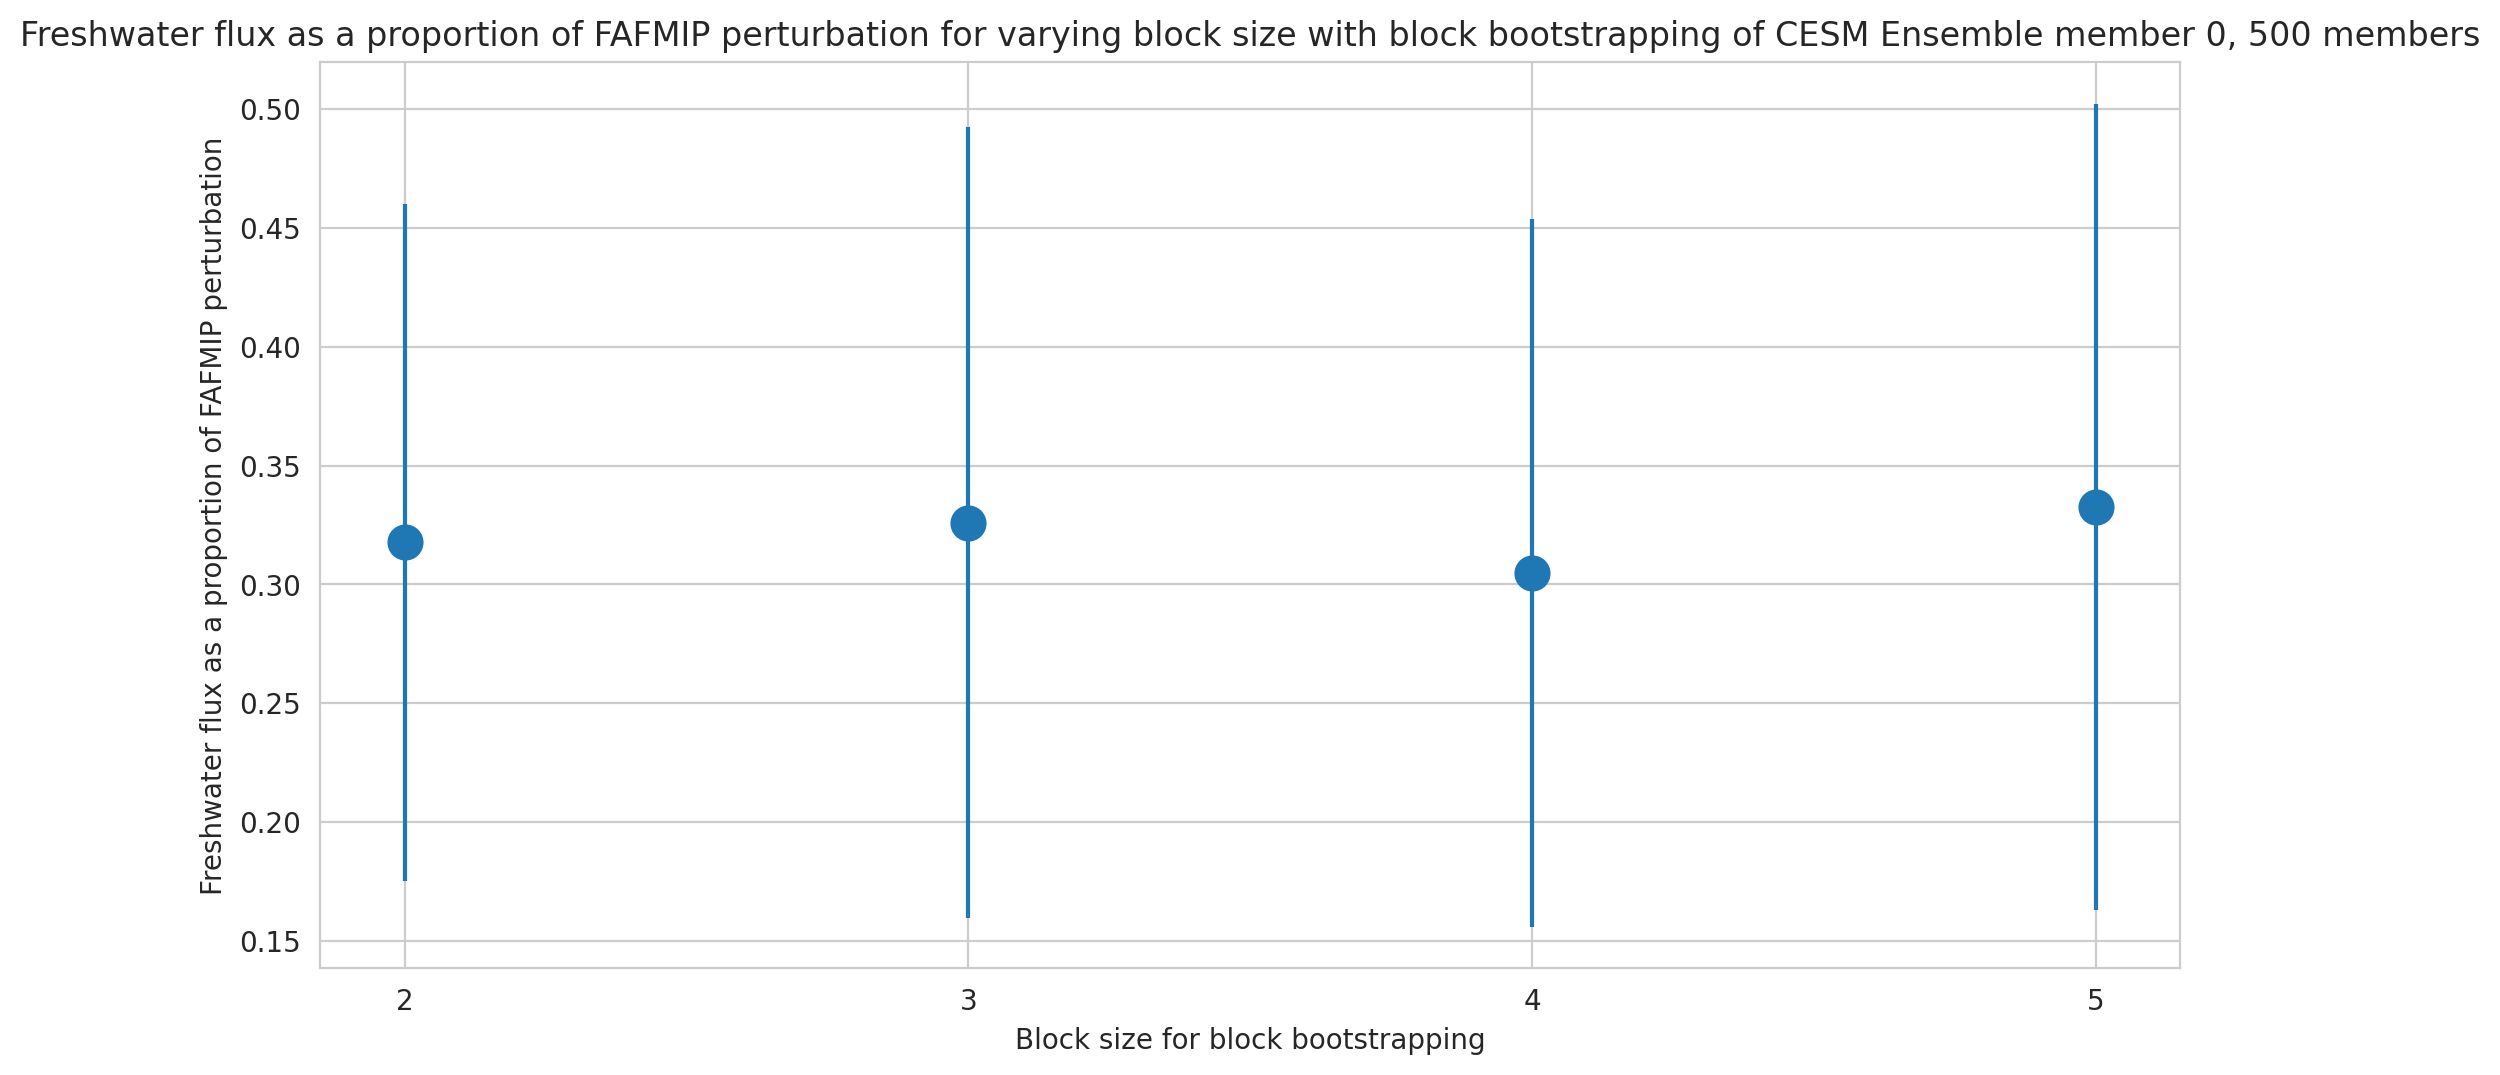

In [26]:
fig,ax=plt.subplots(figsize=(12,6))
plt.errorbar(np.linspace(2,5,4), dep_block_size[0,:], yerr=dep_block_size[1,:],fmt ='o',
        ms=12)
plt.xticks(np.arange(2, 6, 1))
ax.set_xlabel('Block size for block bootstrapping')
ax.set_ylabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.set_title('Freshwater flux as a proportion of FAFMIP perturbation for varying block size with block bootstrapping of CESM Ensemble member '+str(real)+ ', 500 members')

### Different numbers of artificial ensemble members generated
Above, we used 500 members (in our single realization example) and 3000 members (in the .py file which generated the results for all members) when creating the artificial ensemble using block bootstrapping. Here, we test the dependence on the number of members generated. We use data from the results from running run_bootstrap_cesm_ensemble.py as above which found response for all 34 true members around which we created an artificial ensemble for each (up to 3000 members). These results used a block size of 2 years. Here we iterate through taking from 100 up to 3000 of those artificial members and plot the linear response results given these artificial ensemble sizes

In [28]:
with open(cwd+"/pickled_files/bootstrap_change_water_3000_updateaug24", "rb") as fp:   #Pickling so we don't have to rerun
    bootstrap_change_water_3000=pickle.load(fp)

#iterate through 30 different numbers of members (from 100 up to 3000) and check the mean and standard deviation of that number of artificial ensemble members
mean_by_members=np.empty(30) 
std_by_members=np.empty(30)
for j in range(0,30):
    mean_by_members[j]=bootstrap_change_water_3000[real,0:(j+1)*100].mean()
    std_by_members[j]=bootstrap_change_water_3000[real,0:(j+1)*100].std()

Text(0.5, 1.0, 'CESM Ensemble member 0. Freshwater fluxes as proportion of FAFMIP response depending on number of observational members generated')

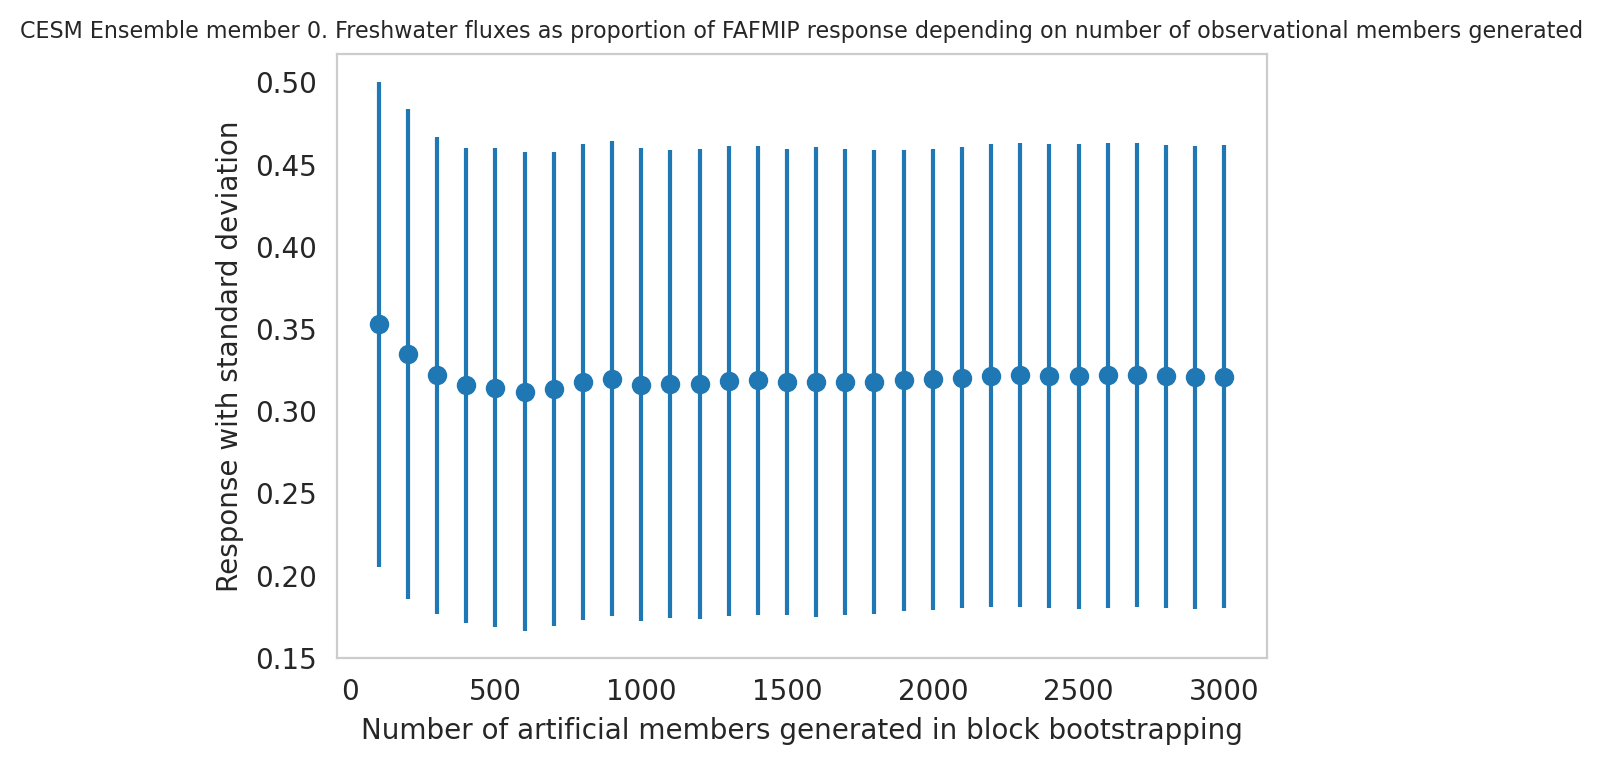

In [30]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
plt.errorbar(np.linspace(100,3000,30),mean_by_members,yerr=std_by_members,fmt ='o',
        ms=6)
ax.xaxis.grid()
ax.yaxis.grid()
plt.xlabel('Number of artificial members generated in block bootstrapping')
plt.ylabel('Response with standard deviation')
plt.title('CESM Ensemble member ' +str(real) +'. Freshwater fluxes as proportion of FAFMIP response depending on number of observational members generated',fontsize=8)